<a href="https://colab.research.google.com/github/ShivdevRajendran/Optical-Character-Recognition-System/blob/main/Optical_Character_Recognition_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

train.py

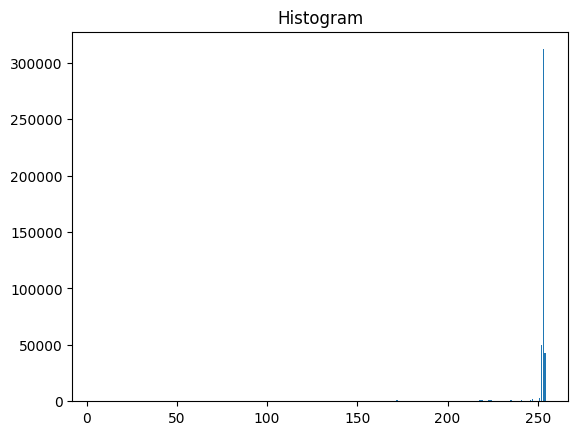

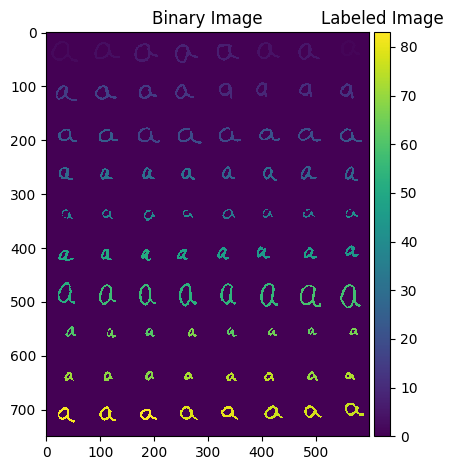

83


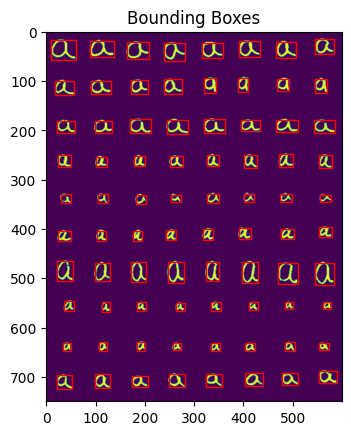

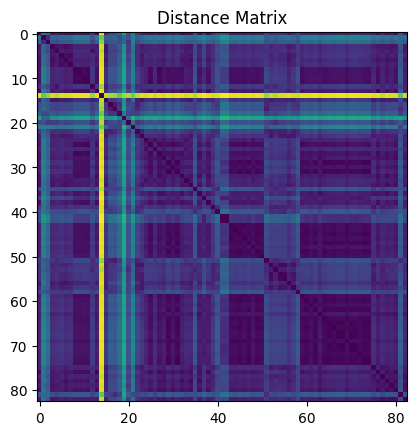

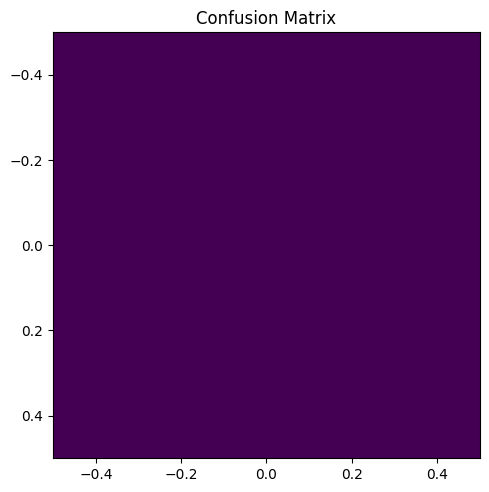

1.0


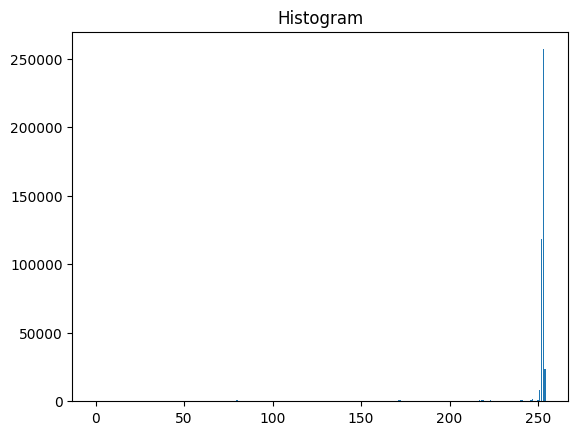

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


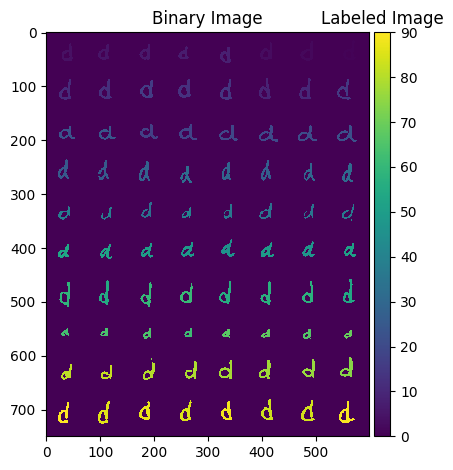

90


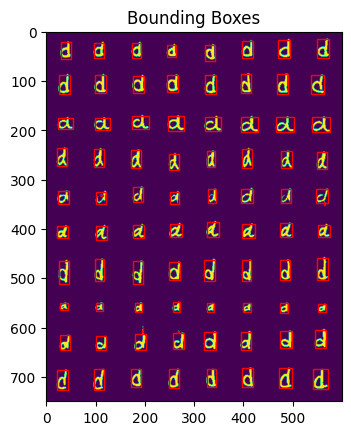

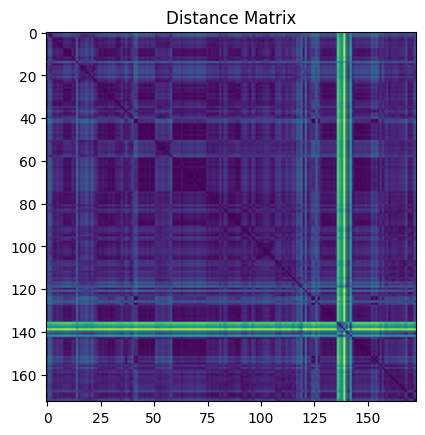

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


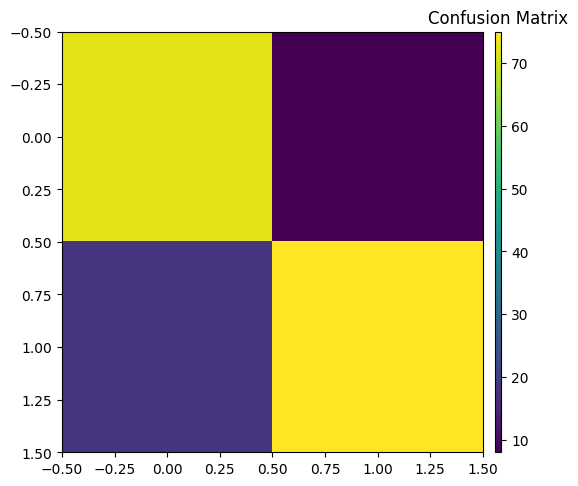

0.8497109826589595


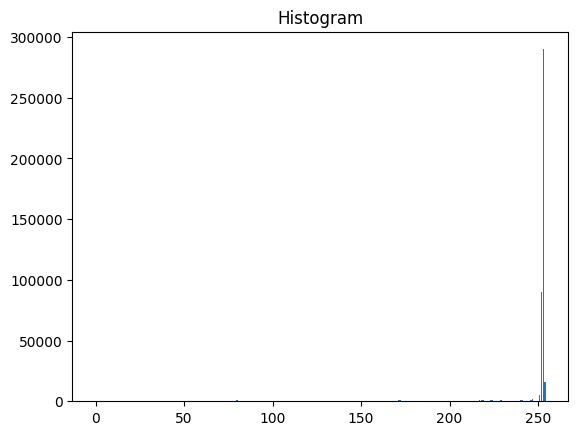

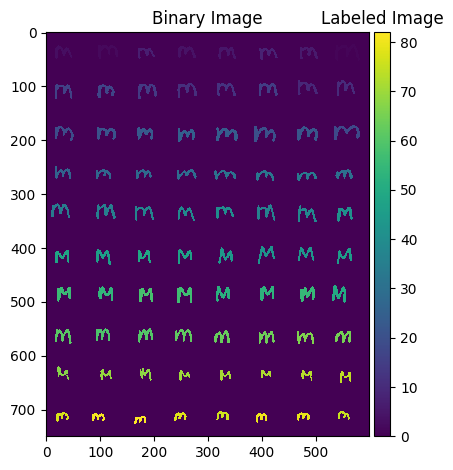

82


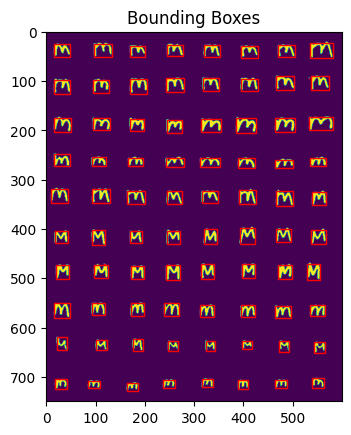

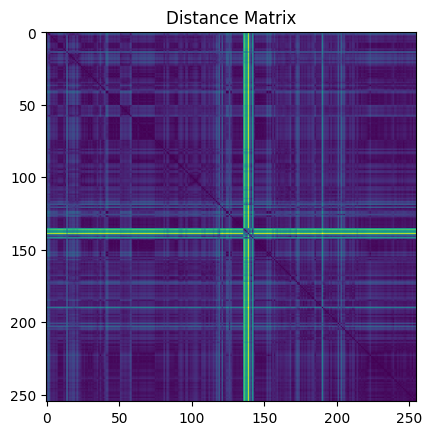

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


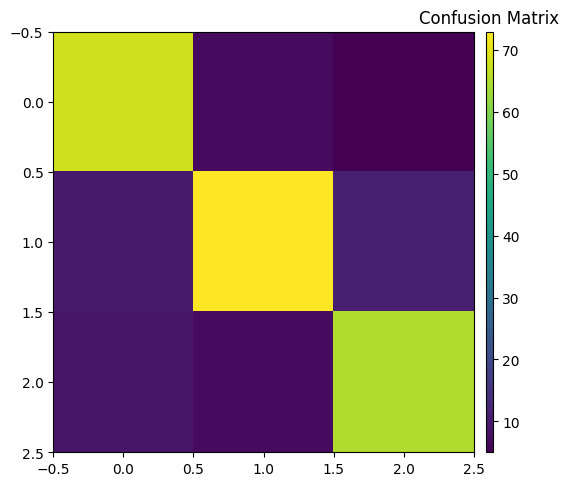

0.807843137254902


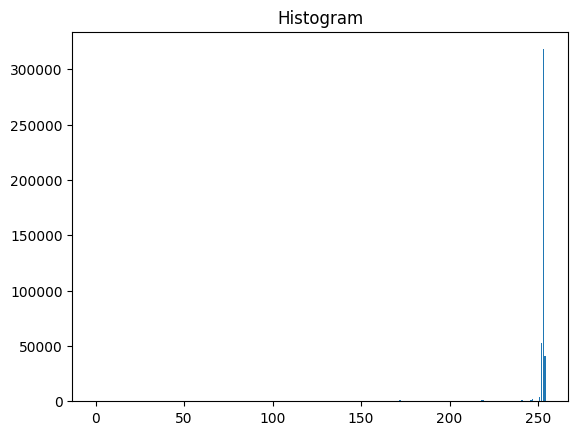

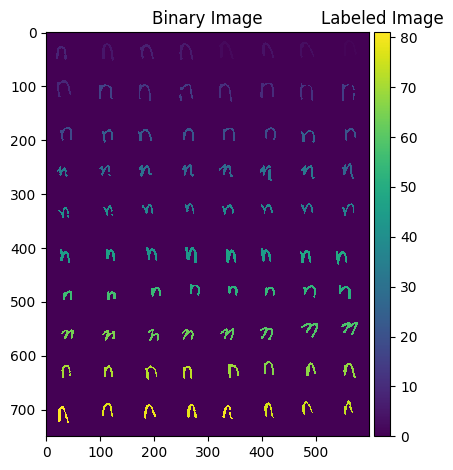

81


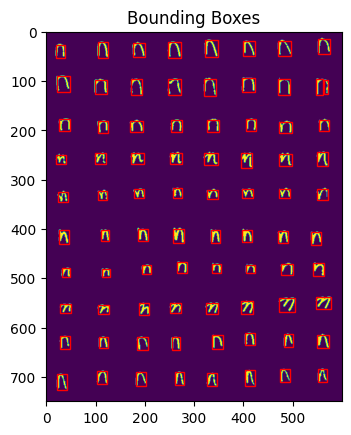

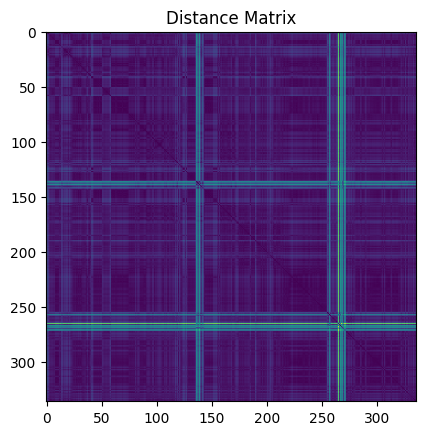

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


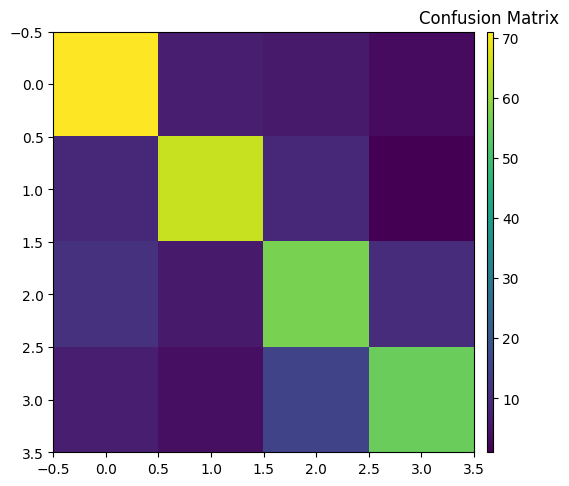

0.7380952380952381


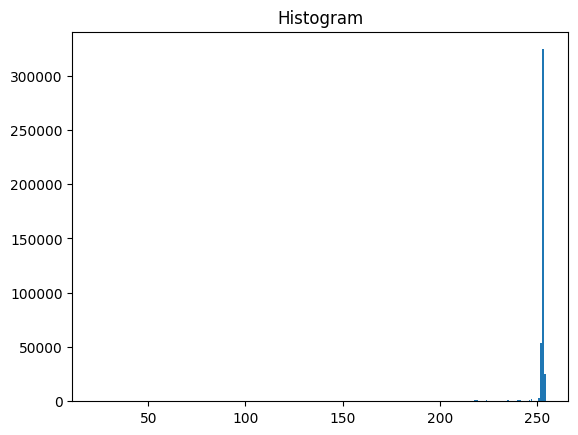

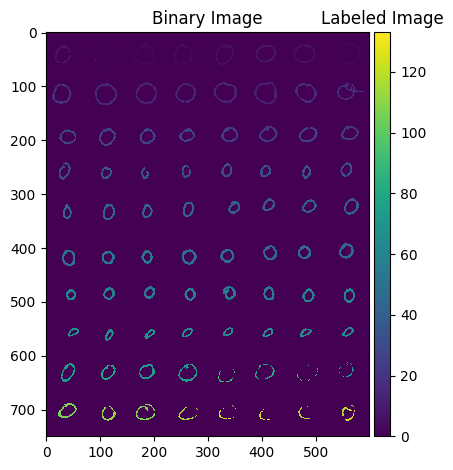

133


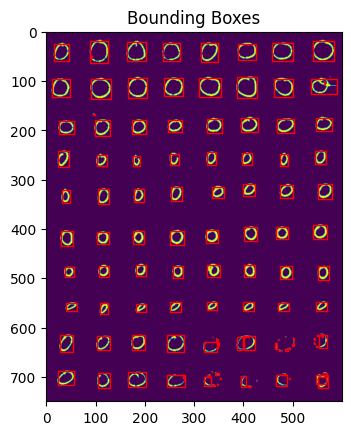

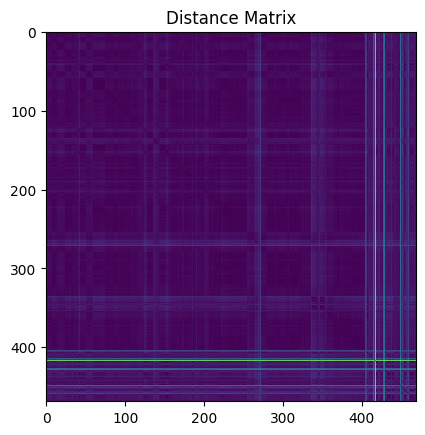

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


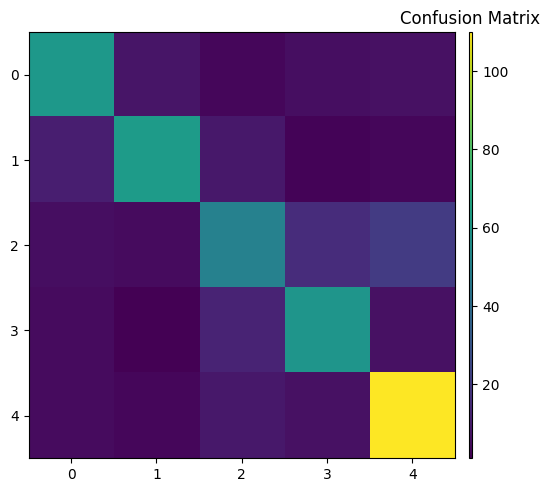

0.7185501066098081


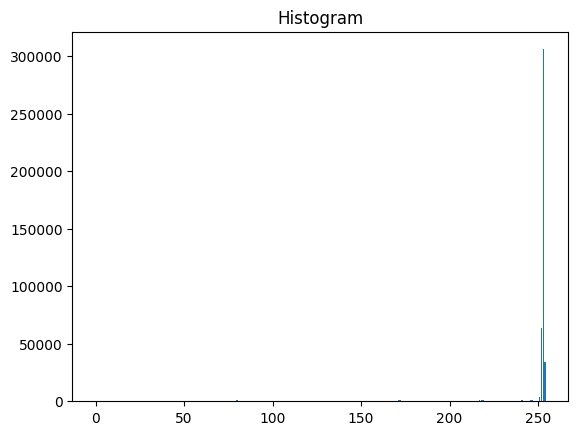

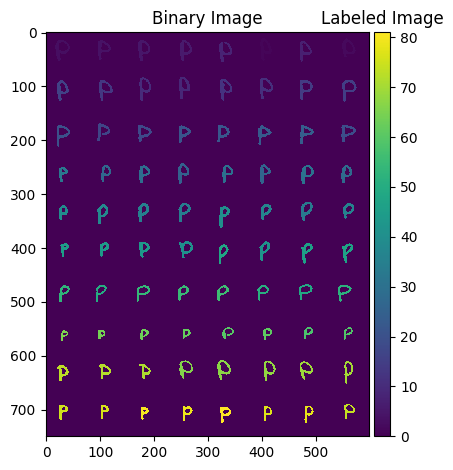

81


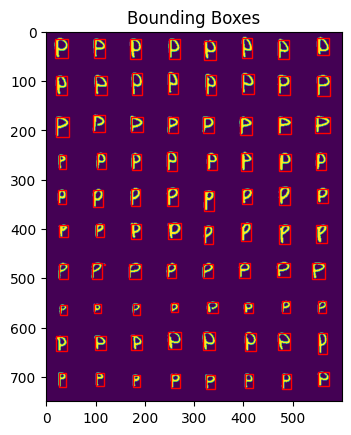

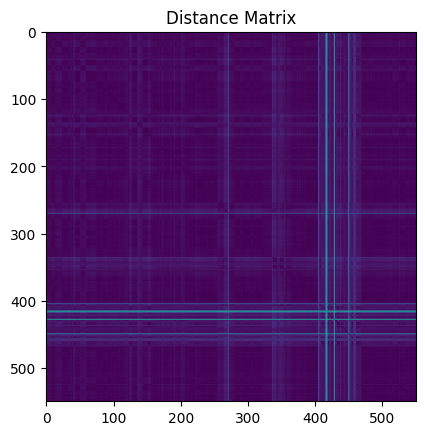

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


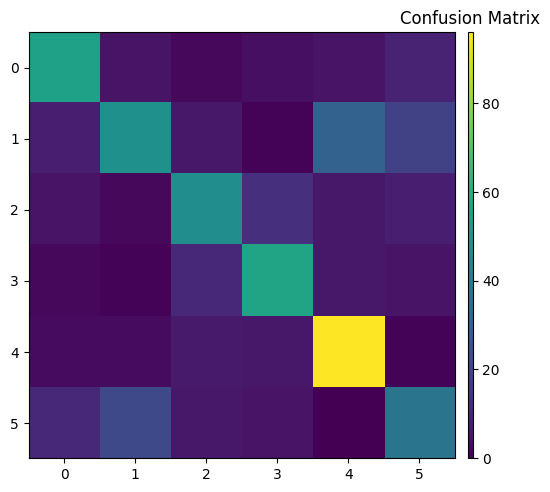

0.6163636363636363


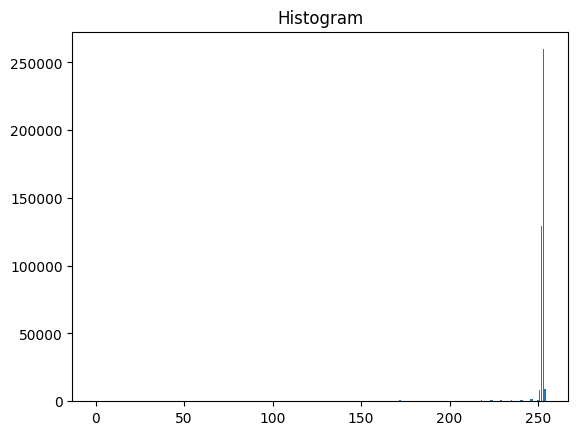

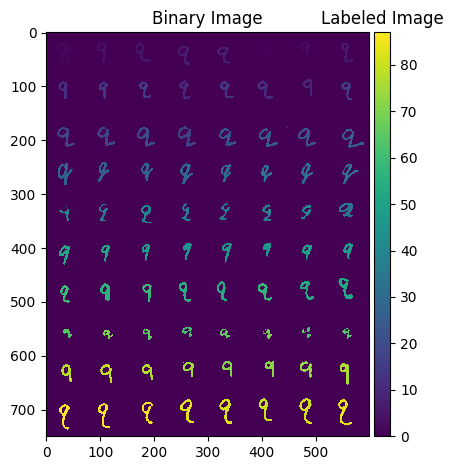

87


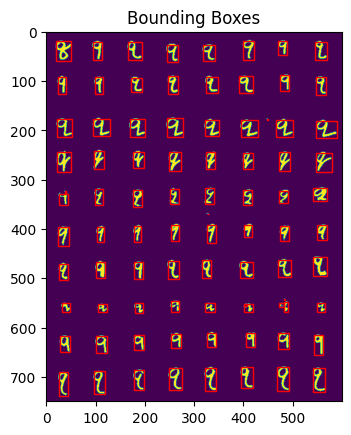

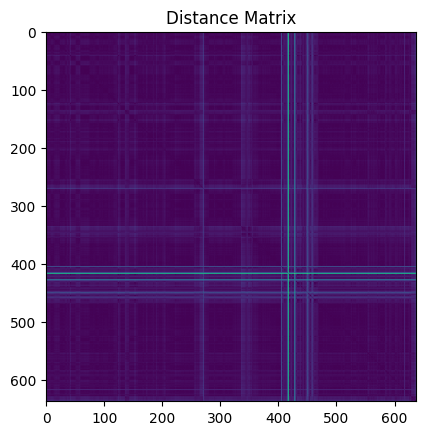

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


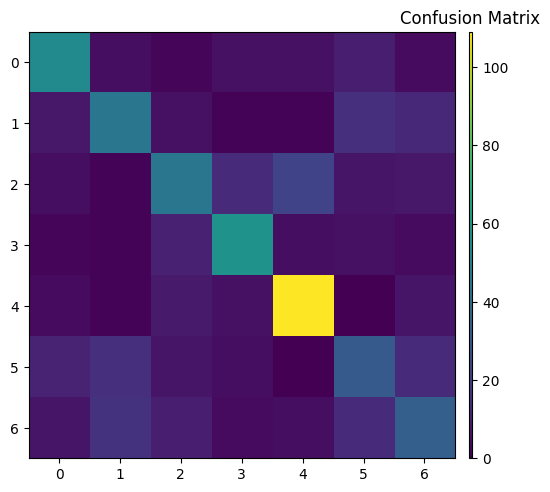

0.576138147566719


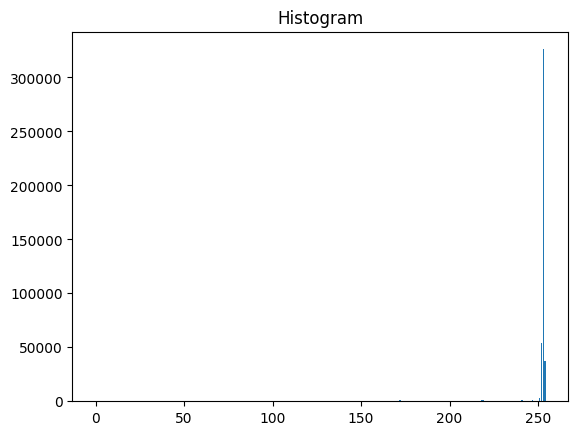

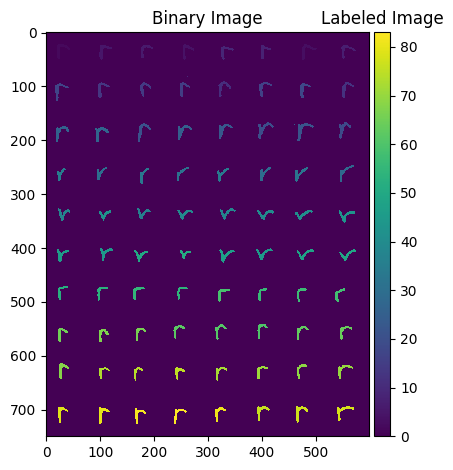

83


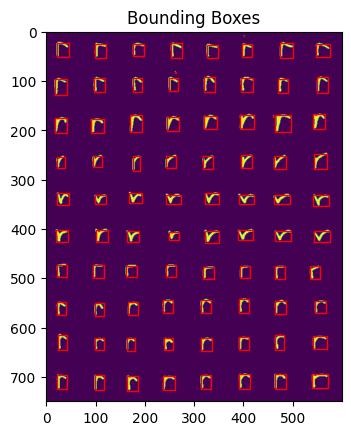

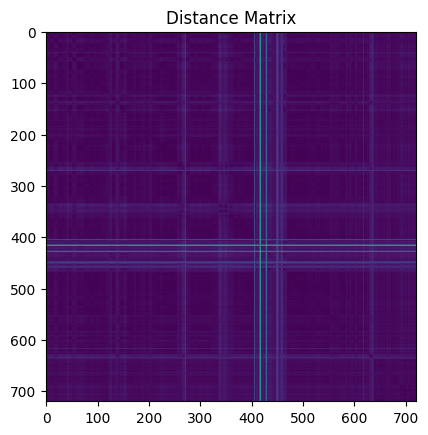

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


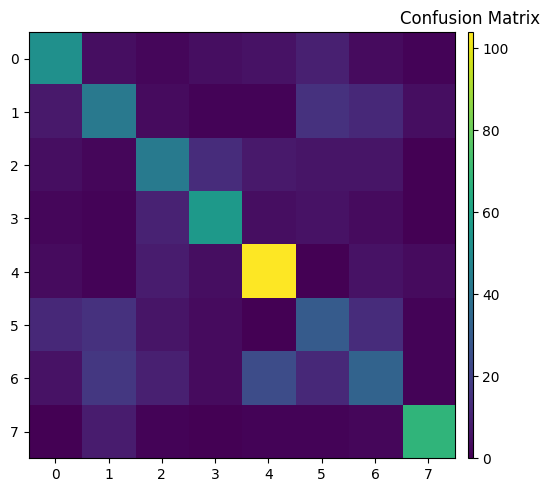

0.5944444444444444


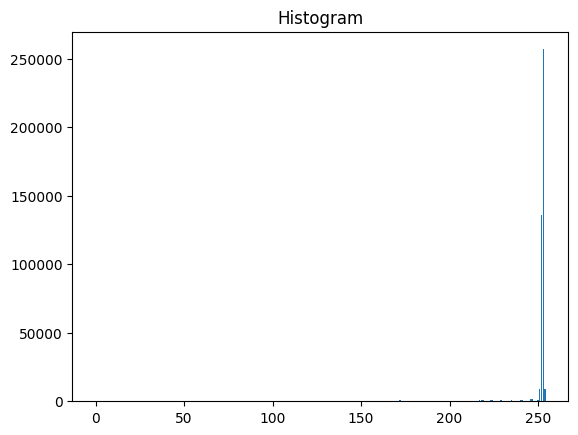

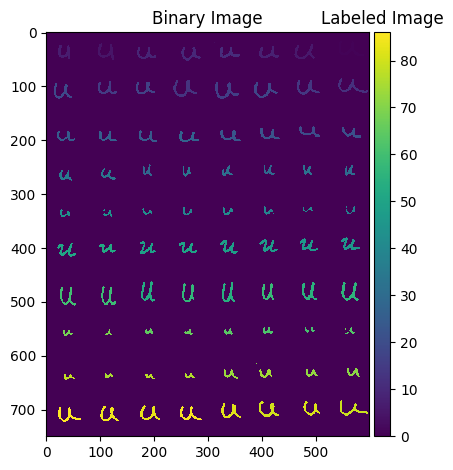

86


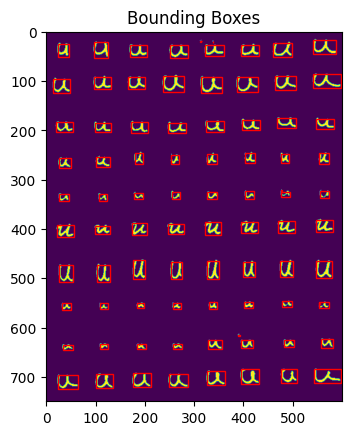

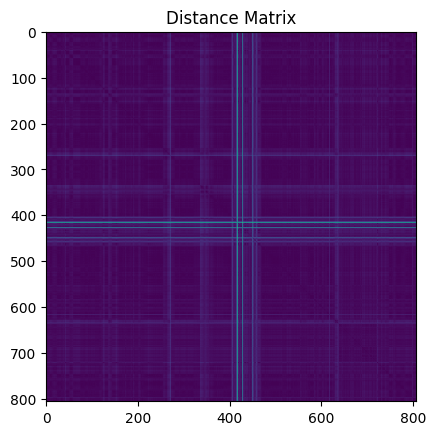

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


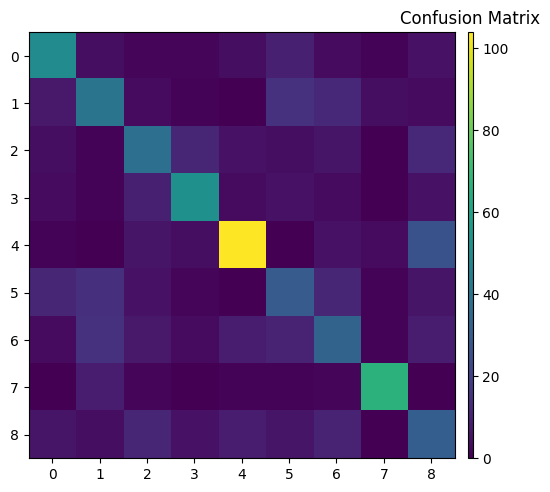

0.5521091811414393


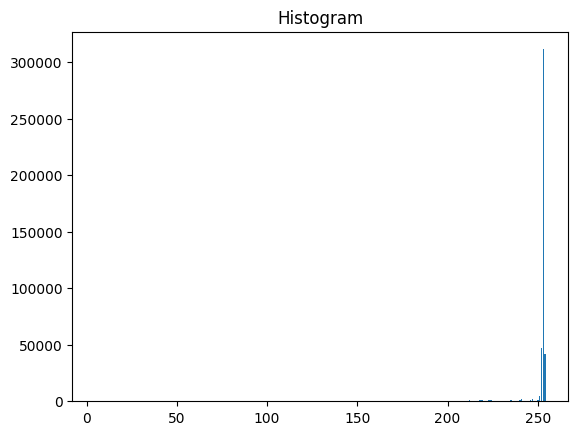

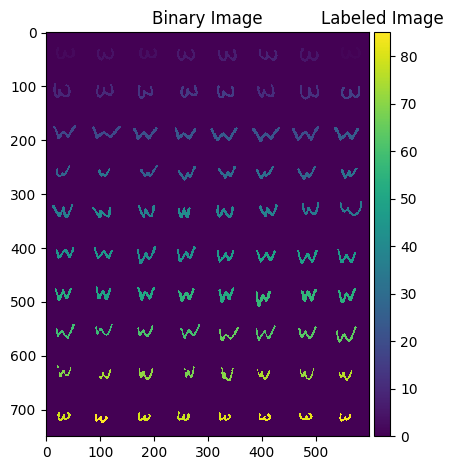

85


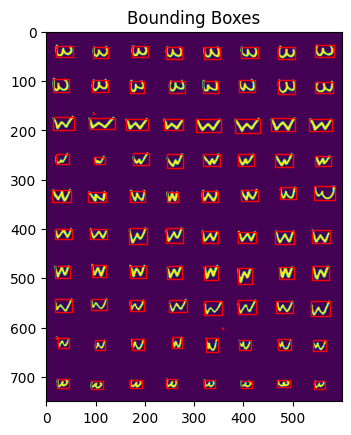

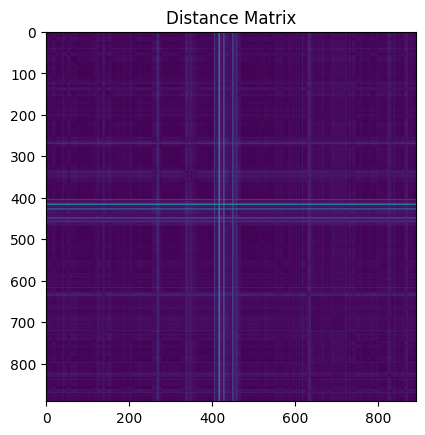

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


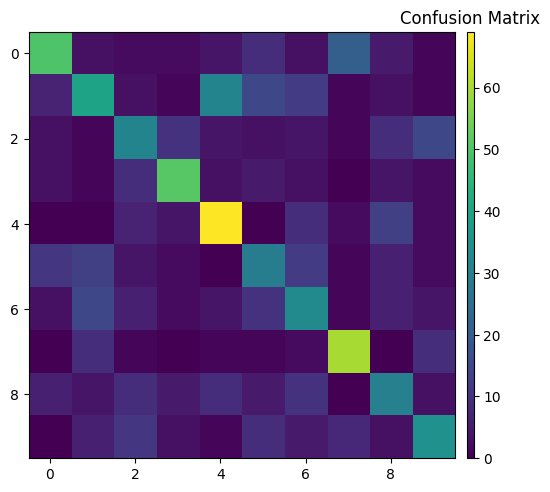

0.48035914702581367


In [ ]:
from skimage import io, exposure, measure
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def train(image_paths, labels, display_plots=True):
  all_features = []
  all_labels = []

  # Load the image
  for i, image_path in enumerate(image_paths):
    img = io.imread(image_path)

  # Calculate histogram
    hist = exposure.histogram(img)
    if display_plots:
      plt.bar(hist[1], hist[0])
      plt.title('Histogram')
      plt.show()

    # Binarization with a threshold of 200
    th = 200
    img_binary = (img < th).astype(np.double)
    io.imshow(img_binary)
    plt.title('Binary Image')
    # Label connected components
    img_label = measure.label(img_binary, background=0)
    io.imshow(img_label)
    plt. title('Labeled Image')
    io.show()
    print(np.amax (img_label))

    # Get regions/connected components
    regions = measure.regionprops(img_label)

    # List to store features for this image
    features = []
    ax = plt.gca()
    for props in regions:
      minr, minc, maxr, maxc = props.bbox
      roi = img_binary[minr:maxr, minc:maxc]

      # Calculate Hu moments for each region
      m = measure.moments(roi)
      cc = m[0, 1] / m[0, 0]
      cr = m[1, 0] / m[0, 0]
      mu = measure.moments_central(roi, center=(cr, cc))
      nu = measure.moments_normalized(mu)
      hu = measure.moments_hu(nu)

      # Store the Hu moments in the features list
      features.append(hu)
      ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor = 'red', linewidth=1))

    if display_plots:
      plt.imshow(img_binary)
      plt.title('Bounding Boxes')
      io.show()

    # Convert features to a numpy array
    features_array = np.array(features)

    # Append features and labels to the overall list
    all_features.extend(features_array)
    all_labels.extend([labels[i]] * len(features))

    # Calculate mean and standard deviation for normalization
    mean = np.mean(all_features, axis=0)
    std = np.std(all_features, axis=0)

    # Normalize features
    normalized_features = (all_features - mean) / std

    # Calculate distances between features
    D = cdist(normalized_features, normalized_features, 'euclidean')

    # Find nearest neighbors excluding itself
    D_sorted = np.argsort(D, axis=1)
    second_closest = D_sorted[:, 1] # Second closest index

    # Find class for the closest match
    closest_labels = [all_labels[idx] for idx in second_closest]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, closest_labels)

    #The Distance Matrix
    distance_matrix = cdist(normalized_features, normalized_features)
    #visualize(distance_matrix, "Distance Matrix")
    if display_plots:
      plt.imshow(distance_matrix)
      plt.title('Distance Matrix')
      plt.show()

    # Sort the rows in Distance Matrix
    # Column 0 is character itself
    # Column 1 is is the closest neighbor
    sorted_rows = np.argsort(distance_matrix, axis=1)

    # The first column contains the indexes of the characters themselves
    first_column_indexes = sorted_rows[:,0]

    # The second column contains the indexes of the predictions
    second_column_indexes = sorted_rows[:,1]

    # Associate the first_column_indexes with the class labels
    Ytrue = np.array([all_labels[idx] for idx in first_column_indexes])

    # Associate the second_column_indexes with the class labels
    Ypred = np.array([all_labels[idx] for idx in second_column_indexes])

    # Confusion Matrix
    confM = confusion_matrix(y_true=Ytrue, y_pred=Ypred)
    io.imshow(confM)
    #confM = better_confusion_matrix(Ytrue, Ypred, img_title='Training/Recognition: Confusion Matrix')

    # Recognition Rate on training
    correct = 0
    total = len(Ytrue)
    for true, pred in zip(Ytrue, Ypred):
      if true == pred:
        correct += 1
    recognition_rate = correct / total

    if display_plots:
      plt.imshow(confM)
      plt.title('Confusion Matrix')
      plt.show()

    print(recognition_rate)

  return confM, recognition_rate

  results = {
      'confusion_matrix': confM,
      'recognition_rate': recognition_rate
      }

image_paths = ['a.bmp', 'd.bmp', 'm.bmp','n.bmp','o.bmp','p.bmp','q.bmp','r.bmp', 'u.bmp', 'w.bmp']
labels = ['a', 'd', 'm','n', 'o', 'p','q','r', 'u', 'w']

conf_matrix = train(image_paths, labels)

Report:


Image Loading and Preprocessing:
The function takes a list of image paths (image_paths) and corresponding labels (labels) as input.
For each image, it loads the image using skimage.io.imread.
It calculates the histogram of the image using skimage.exposure.histogram and displays the histogram.
The image is binarized using a threshold of 200.
Connected components in the binary image are labeled using skimage.measure.label.
The labeled image and binary image are displayed.


Feature Extraction:
The function extracts connected components (regions) using skimage.measure.regionprops.
For each region, it calculates Hu moments, which are used as features to characterize the region.
Bounding boxes are drawn around the regions on the binary image.
The features are normalized.

Nearest Neighbor Search:
Euclidean distances are calculated between normalized features using scipy.spatial.distance.cdist.
Nearest neighbors are identified for each feature vector, excluding itself.
A confusion matrix is computed based on the true labels and the labels of the nearest neighbors.

Distance Matrix Visualization:
The function visualizes the distance matrix using matplotlib.pyplot.imshow.

Confusion Matrix Visualization:
The confusion matrix is visualized using matplotlib.pyplot.imshow.

Recognition Rate Calculation:
The recognition rate is calculated by comparing the true labels with the predicted labels.
Results:

The function returns the confusion matrix and recognition rate.

Function Call:
The function is called with a set of image paths and corresponding labels.
The results, including the confusion matrix and recognition rate, are stored in the results dictionary.